In [13]:
import pandas as pd
import numpy as np
import seaborn as sns

In [14]:
def calc_mortgage(csv_path, downpayment, amortization, int_rate):
    df = pd.read_csv("{0}".format(csv_path))
    df['down_payment'] = df['price'] * downpayment
    df['loan_amount'] = df['price'] - df['down_payment']
    def calc_mortgage_payment(loan_amount, amortization_period=amortization, yearly_rate=int_rate):
        monthly_interest_rate = ((1 + yearly_rate)**(1 / 12) - 1)
        payment = np.pmt(rate=monthly_interest_rate, nper=12*amortization_period, pv=loan_amount)
        return payment
    df['mortgage_payment'] = df['loan_amount'].apply(calc_mortgage_payment)
    return df


In [15]:
def calc_property_tax(df, rate):
    df['property_tax'] = (df['PRICE'] * rate * -1) / 12
    return df

In [16]:
def calc_insurance(price):
    premium_per_dollar_insured =  900 / 200000
    monthly_insurance = ((premium_per_dollar_insured * price) / 12) * -1
    return monthly_insurance

In [17]:

def get_rent_per_sqft(df):
    zip_rents = pd.read_csv("0_raw_data/Zip_MedianRentalPricePerSqft_Mfr5Plus.csv")
    zip_rents = pd.melt(zip_rents, 
                        id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], 
                        var_name='year_month',
                       value_name = 'rent_per_sqft')
    zip_rents = zip_rents[zip_rents['year_month'] == '2019-11']
    zip_rents = zip_rents[['RegionName', 'rent_per_sqft']]
    df = df.merge(zip_rents, how = 'left', left_on='ZIP OR POSTAL CODE', right_on='RegionName')
    df['rent_per_sqft'].fillna(1.297577855, inplace=True)
    df['rent'] = df['rent_per_sqft'] * df['SQUARE FEET']
    df['rent'].fillna((df['rent'].mean()), inplace=True)
    return df

In [18]:
def run_rental_calculator(csv_path, downpayment, amortization, int_rate, prop_tax_rate, vacancy, maintenance, capex, property_management):
    df = calc_mortgage(csv_path="{0}".format(csv_path), downpayment=downpayment, amortization=amortization, int_rate=int_rate)
    df = calc_property_tax(df, rate=prop_tax_rate)
    df['insurance_payment'] = df['PRICE'].apply(calc_insurance)
    df = get_rent_per_sqft(df=df)
    df['vacancy'] = df['rent'] * vacancy * -1
    df['maintenance'] = df['rent'] * maintenance * -1
    df['capex'] = df['rent'] * capex * -1
    df['property_management'] = df['rent'] * property_management * -1
    df['water'] = -100
    df['electricity'] = 0
    df['garbage'] = -100
    df['monthly_cashflow'] = df['rent'] + df['mortgage_payment'] + df['property_tax'] + df['insurance_payment'] + df['vacancy'] + + df['maintenance'] +  df['capex'] +  df['property_management'] + df['water'] + df['electricity'] + df['garbage']
    df['coc_return'] = df['monthly_cashflow'] * 12 / df['down_payment']
    df = df.drop_duplicates()
    return df


In [19]:
df_final = run_rental_calculator(csv_path='0_raw_data/redfin_for_sale.csv', 
                      downpayment=.25, 
                      amortization=30, 
                      int_rate=0.045, 
                      prop_tax_rate=0.01937, 
                      vacancy=.10, 
                      maintenance=0.10, 
                      capex=0.10, 
                      property_management=0.10)


In [20]:
# df_final = df_final[(df_final['PRICE'] >= 75000) & (df_final['PRICE'] <= 100000)]

In [21]:
df_final.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
SOLD DATE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP OR POSTAL CODE,21.0,53216.10,6.70,53207.00,53207.00,53219.00,53222.00,53222.00
PRICE,21.0,270219.05,189904.16,84900.00,147000.00,208500.00,310000.00,829900.00
BEDS,13.0,4.77,1.01,4.00,4.00,4.00,6.00,6.00
BATHS,13.0,2.00,0.00,2.00,2.00,2.00,2.00,2.00
SQUARE FEET,17.0,2140.59,605.04,952.00,1736.00,2080.00,2608.00,3150.00
LOT SIZE,20.0,6315.75,4126.52,3049.00,3484.00,5227.00,6642.75,20473.00
YEAR BUILT,21.0,1944.00,27.16,1899.00,1926.00,1953.00,1956.00,1990.00
DAYS ON MARKET,21.0,86.90,77.82,1.00,10.00,81.00,141.00,247.00
$/SQUARE FEET,17.0,100.82,46.02,40.00,70.00,93.00,122.00,194.00


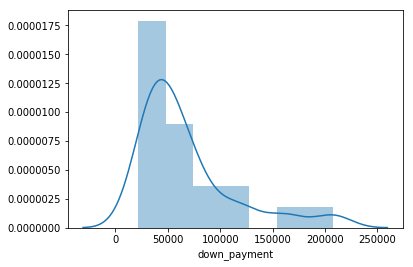

In [22]:
sns.distplot(df_final['down_payment'])

In [23]:

df_final = df_final.sort_values(by='coc_return')
# df_final = df_final[df_final['rent'] < 2000]
df_final.to_csv("1_clean_data/redfin_for_sale.csv")

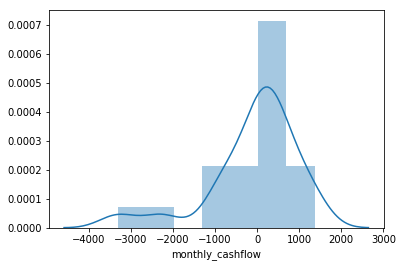

In [24]:
sns.distplot(df_final['monthly_cashflow'])

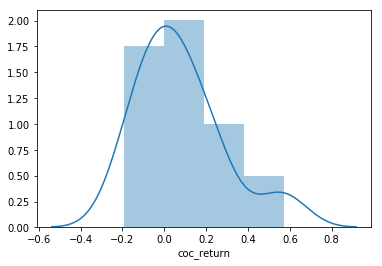

In [25]:
sns.distplot(df_final['coc_return'])